### gdna informations https://ftp.ncbi.nlm.nih.gov/genomes/GENOME_REPORTS/eukaryotes.txt

### mtdna informations https://www.ncbi.nlm.nih.gov/genome/browse#!/organelles/organelles.csv

### taxonomy descriptions https://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump/taxdump_readme.txt
### taxonomy informations https://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump/new_taxdump.zip és ebből a nodes.dmp
### taxonomy ranks Taxallnomy: an extension of NCBI Taxonomy that produces a hierarchically complete taxonomic tree (Table 1.) https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04304-3

In [1]:
#import dependencies
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
#get nuclear genome informations
gdnas=pd.read_csv('../data/eukaryotes.txt',sep='\t',index_col=0)
gdnas.head(n=2)

,TaxID,BioProject Accession,BioProject ID,Group,SubGroup,Size (Mb),GC%,Assembly Accession,Replicons,WGS,Scaffolds,Genes,Proteins,Release Date,Modify Date,Status,Center,BioSample Accession
#Organism/Name,,,,,,,,,,,,,,,,,,
Neopyropia yezoensis,2788,PRJNA589917,589917,Other,Other,107.591,64.8454,GCA_009829735.1,chromosome 1:CM020618.1; chromosome 2:CM020619...,WMLA01,28,-,-,2020/01/03,2020/01/06,Chromosome,Ocean University,SAMN13316713
Emiliania huxleyi CCMP1516,280463,PRJNA77753,77753,Protists,Other Protists,167.676,64.5,GCA_000372725.1,-,AHAL01,7795,38549,38554,2013/04/19,2014/08/01,Scaffold,JGI,SAMN02744062


In [3]:
#get mitochondrial genome informations
mtdnas=pd.read_csv('../data/organelles.csv',index_col=0)
mtdnas.head(n=2)

,Organism Groups,Strain,BioSample,BioProject,Size(Mb),GC%,Type,Replicons,CDS,Release Date
#Organism Name,,,,,,,,,,
(Cyprinus carpio 'mirror' x Cyprinus carpio 'singuonensis') x Carassius auratus red var.,Eukaryota;Animals;Fishes,NaN,NaN,PRJNA353408,0.016581,43.3207,mitochondrion,NC_031807.1/KU146531.1,13,2016-11-14T00:00:00Z
Aacanthocnema dobsoni,Eukaryota;Animals;Insects,NaN,NaN,PRJNA483618,0.015179,21.9382,mitochondrion,NC_038132.1/MG989216.1,13,2018-07-31T00:00:00Z


In [4]:
#get phylogenetic informations about nodes
nodes=pd.read_csv('../data/nodes.dmp',sep='\t',header=None)

#delete non informative columns
fil=nodes.apply(lambda column:len(column.unique())!=1,axis=0)
nodes=nodes[fil.index[fil]]

#rename existing columns
nodes.rename(columns={
    0:'tax_id',
    2:'parent_tax_id',
    4:'rank'
},inplace=True)
nodes.head(n=3)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tax_id,parent_tax_id,rank,6,8,10,12,14,16,18,20,24
0,1,1,no rank,NaN,8,0,1,0,0,0,0,NaN
1,2,131567,superkingdom,NaN,0,0,11,0,0,0,0,NaN
2,6,335928,genus,NaN,0,1,11,1,0,1,0,NaN


In [5]:
#taxonomy ranks input
taxonomy_ranks=[
        'superkingdom','kingdom','subkingdom','superphylum',
        'phylum','subphylum','infraphylum','superclass',
        'class','subclass','infraclass','cohort','subcohort',
        'superorder','order','suborder','infraorder','parvorder',
        'superfamily','family','subfamily','tribe','subtribe',
        'genus','subgenus','section','subsection','series',
        'subseries','species group','species subgroup',
        'species','forma specialis','subspecies',
        'varietas','subvariety','forma',
        'serogroup','serotype','strain','isolate'
    ]

In [6]:
#sort taxonomy ranks https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04304-3/tables/1
taxonomy_ranks=pd.Series(
    data=np.arange(0,len(taxonomy_ranks)),
    index=taxonomy_ranks
)

In [7]:
#get phylogenetic informations about nodes
rankedlineage=pd.read_csv('../data/rankedlineage.dmp',sep='\t',header=None)
rankedlineage=rankedlineage.rename(columns={
    0:'tax_id',
    2:'tax_name',
    4:'species',
    6:'genus',
    8:'family',
    10:'order',
    12:'order',
    14:'class',
    16:'phylum',
    18:'kingdom',
    20:'superkingdom'
                          })
#delete non informative columns
fil=rankedlineage.apply(lambda column:len(column.unique())!=1,axis=0)
rankedlineage=rankedlineage[fil.index[fil]]
rankedlineage=rankedlineage.dropna()
rankedlineage.head(n=2)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,8,10,12,14,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tax_id,tax_name,species,genus,family,order,order,order,order,class,phylum,kingdom
556755,2678697,[Arthonia] cinnabarina f. cuspidans,Coniocarpon cinnabarinum,Coniocarpon,Arthoniaceae,Arthoniales,Arthoniomycetes,Arthoniales,Arthoniomycetes,Ascomycota,Fungi,Eukaryota
556984,86792,Dendrographa alectoroides f. alectoroides,Dendrographa alectoroides,Dendrographa,Roccellaceae,Arthoniales,Arthoniomycetes,Arthoniales,Arthoniomycetes,Ascomycota,Fungi,Eukaryota


In [33]:
#get numt csv files
def read_csv(filename):
    try:
        df=pd.read_csv(f'/Volumes/motilin/balint/numt/ncbi/{filename}')
        df['organism_name']=len(df)*[' '.join(filename.split('_')[:-1])]
        return df
    except:
        return np.nan

dfs=pd.Series(os.listdir('/Volumes/motilin/balint/numt/ncbi/')).apply(read_csv)

dfs=dfs.dropna()
numts=pd.concat(dfs.tolist())
numts.head(n=3)

,Unnamed: 0,score,eg2_value,e_value,genomic_id,genomic_start,mitochondrial_start,genomic_length,mitochondrial_length,genomic_strand,mitochondrial_strand,genomic_size,genomic_sequence,mitochondrial_sequence,organism_name
0,2,2781.0,0.000000e+00,0.000000e+00,NC_056031.1,28008908.0,2890.0,3882.0,3906.0,+,+,134369076.0,AGATGCGATAAAACTATTCATCAAAGAACCACTACGGCCACTAGCA...,AGATGCAATAAAACTATTTATCAAAGAACCCCTACGACCACTAGCA...,Peromyscus maniculatus
1,4,677.0,2.000000e-305,3.000000e-309,NC_056022.1,34379848.0,4471.0,1482.0,1491.0,+,+,78974444.0,GAATTCCCACTACATTCCCCTAAAATCCTTCCCTCACACTTCTCAA...,GAATAATCGCTGTACTTCCATTCAACCCATCCCTTACAATACTAAA...,Peromyscus maniculatus
2,6,657.0,6.300000e-296,9.400000e-300,NC_056027.1,6347918.0,2456.0,2376.0,2378.0,+,+,70296724.0,ATTAATGGTTAATCTGTTCAACGATTAAAGTCCTACCTGGTCTGAG...,ATTAATGGTTCGTTTGTTCAACGATTAAAGTCCTACGTGATCTGAG...,Peromyscus maniculatus


In [97]:
#code organism names
organism_indexer=pd.Series(
    data=np.arange(0,len(numts['organism_name'].unique()),1),
    index=numts['organism_name'].unique()
)
#and add it to numt df
numts['organism_label']=pd.Series(numts['organism_name']).apply(lambda organism_name: organism_indexer[organism_name])

In [51]:
#calculate GC ratio for every numts
numts['numt_gc']=numts['genomic_sequence'].apply(
    lambda seq:(seq.upper().count('G')+seq.upper().count('C'))/len(seq.replace('N',''))
)

In [99]:
#get data from gdnas df
def get_data(organism_name,column_name):
    try:
        return gdnas.loc[organism_name][column_name].tolist()
    except:
        return np.nan

In [100]:
g_GC=pd.Series(numts['organism_name']).apply(get_data,args=('GC%',))

In [84]:
g_Size=pd.Series(numts['organism_name']).apply(get_data,args=('Size (Mb)',))

In [90]:
g_scaffolds=pd.Series(numts['organism_name']).apply(get_data,args=('Scaffolds',))

In [87]:
g_genes=pd.Series(numts['organism_name']).apply(get_data,args=('Genes',))

In [88]:
g_proteins=pd.Series(numts['organism_name']).apply(get_data,args=('Proteins',))

In [103]:
#add the data to the numts df
numts['g_gc']=g_GC
numts['full_g_size']=g_Size
numts['scaffolds_number']=g_scaffolds
numts['genes_number']=g_genes
numts['proteins_number']=g_proteins

In [152]:
#function for calculating means if more datapoints exist for one instance
def clear_instance(cell):
    if type(cell)!=list and pd.isna(cell)==True:
        return cell
    else:
        if type(cell)!=list:
            return cell
        else:
            updated_list=[]
            for i in cell:
                try:
                    updated_list.append(float(i))
                except:
                    pass
            return np.mean(updated_list)

In [153]:
#caluclate means for columns
numts['g_gc']=numts['g_gc'].apply(clear_instance)
numts['full_g_size']=numts['full_g_size'].apply(clear_instance)
numts['scaffolds_number']=numts['scaffolds_number'].apply(clear_instance)
numts['genes_number']=numts['genes_number'].apply(clear_instance)
numts['proteins_number']=numts['proteins_number'].apply(clear_instance)

In [154]:
#get mitochondrial data
def get_mt_data(organism_name,column_name):
    try:
        return mtdnas.loc[organism_name][column_name].tolist()
    except:
        return np.nan

In [156]:
#get data for mtdnas
mt_Size=numts['organism_name'].apply(get_mt_data,args=('Size(Mb)',))
mt_GC=numts['organism_name'].apply(get_mt_data,args=('GC%',))
mt_CDS=numts['organism_name'].apply(get_mt_data,args=('CDS',))

In [158]:
#add mtdna data to numts df
numts['full_mt_size']=mt_Size
numts['mt_gc']=mt_GC
numts['mt_cds']=mt_CDS

In [161]:
#calculate means for columns
numts['full_mt_size']=numts['full_mt_size'].apply(clear_instance)
numts['mt_gc']=numts['mt_gc'].apply(clear_instance)
numts['mt_cds']=numts['mt_cds'].apply(clear_instance)

In [164]:
#dropnas
numts=numts.dropna(subset=['g_gc','full_g_size','scaffolds_number','genes_number','proteins_number','full_mt_size','mt_gc','mt_cds'])

In [183]:
#export csv
numts.to_csv('../results/tsne_input.csv',index=False)

In [9]:
#import numts
numts=pd.read_csv('../results/tsne_input.csv',index_col=0)
numts

,score,eg2_value,e_value,genomic_id,genomic_start,mitochondrial_start,genomic_length,mitochondrial_length,genomic_strand,mitochondrial_strand,...,organism_label,numt_gc,g_gc,full_g_size,scaffolds_number,genes_number,proteins_number,full_mt_size,mt_gc,mt_cds
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,10607.0,0.000,0.000000,NC_057863.1,285246352.0,4543.0,10804.0,10807.0,+,+,...,1,0.382494,41.27250,2041.294133,3986.666667,31081.0,43302.0,0.016330,37.57315,6.5
2,3500.0,0.000,0.000000,NC_057864.1,416673194.0,11301.0,4022.0,4049.0,+,+,...,1,0.380823,41.27250,2041.294133,3986.666667,31081.0,43302.0,0.016330,37.57315,6.5
4,2448.0,0.000,0.000000,NC_057865.1,206469347.0,6.0,2700.0,2711.0,+,+,...,1,0.371819,41.27250,2041.294133,3986.666667,31081.0,43302.0,0.016330,37.57315,6.5
6,1961.0,0.000,0.000000,NC_057865.1,206472039.0,12714.0,2271.0,2276.0,+,+,...,1,0.392794,41.27250,2041.294133,3986.666667,31081.0,43302.0,0.016330,37.57315,6.5
8,1805.0,0.000,0.000000,NC_057861.1,736287349.0,7312.0,1843.0,1843.0,+,+,...,1,0.376017,41.27250,2041.294133,3986.666667,31081.0,43302.0,0.016330,37.57315,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,40.0,0.031,0.000005,NC_032651.1,94343359.0,13347.0,96.0,96.0,+,-,...,141,0.250000,42.13995,2707.150000,108220.500000,26229.0,35992.0,0.016341,39.41620,13.0
840,40.0,0.031,0.000005,NC_032671.1,6914560.0,9506.0,92.0,92.0,+,-,...,141,0.369565,42.13995,2707.150000,108220.500000,26229.0,35992.0,0.016341,39.41620,13.0
842,40.0,0.031,0.000005,NC_032675.1,51778677.0,4658.0,74.0,74.0,+,-,...,141,0.405405,42.13995,2707.150000,108220.500000,26229.0,35992.0,0.016341,39.41620,13.0


In [171]:
X=numts[['score','eg2_value','e_value','genomic_start','genomic_length','mitochondrial_length','numt_gc',
        'g_gc','full_g_size','scaffolds_number','genes_number','proteins_number','full_mt_size','mt_gc',
        'mt_cds']]
y=numts['organism_label']

In [10]:
X=numts[[
    'score','eg2_value','e_value','genomic_start','genomic_length','mitochondrial_length','numt_gc',
        ]]
y=numts['organism_label']

In [58]:
X_normalized=StandardScaler().fit(X).transform(X)
tsne = TSNE(random_state = 0,perplexity=30)
X_tsne = tsne.fit_transform(X_normalized)

/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_20826/2701247593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['x']=X_tsne[:,0]
/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_20826/2701247593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['y']=X_tsne[:,1]
/var/folders/g2/9pvgl5793mxgz8dg4mhwym0m0000gn/T/ipykernel_20826/2701247593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Text(0, 0.5, 'tSNE2')

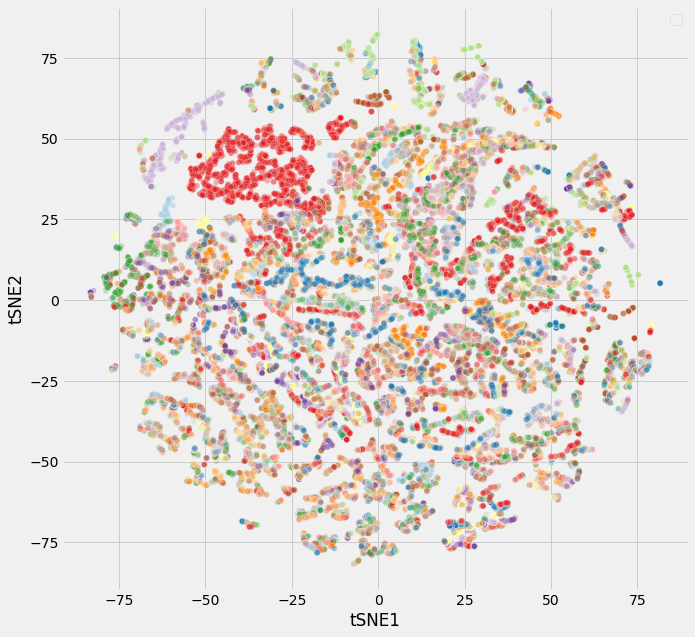

In [60]:
X['x']=X_tsne[:,0]
X['y']=X_tsne[:,1]
X['label']=y
plt.style.use('fivethirtyeight')
fig,axs=plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(
    x='x',
    y='y',
    hue='label',
    data=X,
    palette='Paired',
    alpha=.3,
    ax=axs
)
plt.legend([])
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
#plt.savefig('../results/ncbi_tSNE.png',dpi=450)